In [2]:
# --- Install pymc v4 and dependencies ---
!pip install pymc arviz --quiet

In [3]:
# --- Imports ---
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

In [4]:
# --- Load dataset ---
df = pd.read_csv('BrentOilPrices.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')
df = df.reset_index(drop=True)

/tmp/ipython-input-1171582488.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


In [5]:
# --- Calculate log returns ---
df['LogReturn'] = np.log(df['Price']) - np.log(df['Price'].shift(1))
df = df.dropna().reset_index(drop=True)

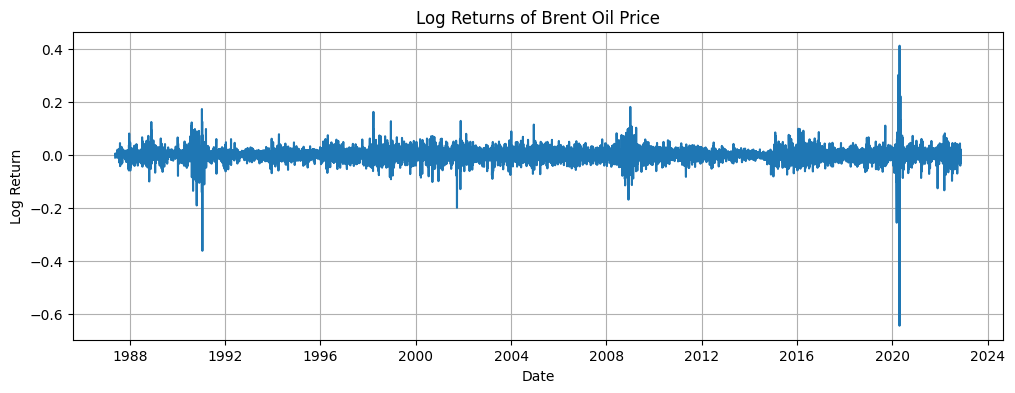

In [6]:
# --- Visualize original and log returns ---
plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['LogReturn'], label='Log Return')
plt.title('Log Returns of Brent Oil Price')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.show()

In [7]:
# --- Model: Single Change Point in Log Returns ---
returns = df['LogReturn'].values
n = len(returns)

with pm.Model() as model:
    # Change point
    tau = pm.DiscreteUniform('tau', lower=0, upper=n)

    # Means before and after
    mu1 = pm.Normal('mu1', mu=0, sigma=1)
    mu2 = pm.Normal('mu2', mu=0, sigma=1)

    # Shared standard deviation
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Mean depending on change point
    mu = pm.math.switch(tau >= np.arange(n), mu1, mu2)

    # Likelihood
    obs = pm.Normal('obs', mu=mu, sigma=sigma, observed=returns)

    # Sampling
    trace = pm.sample(2000, tune=1000, cores=2, random_seed=42)


Output()

ERROR:pymc.stats.convergence:There were 336 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


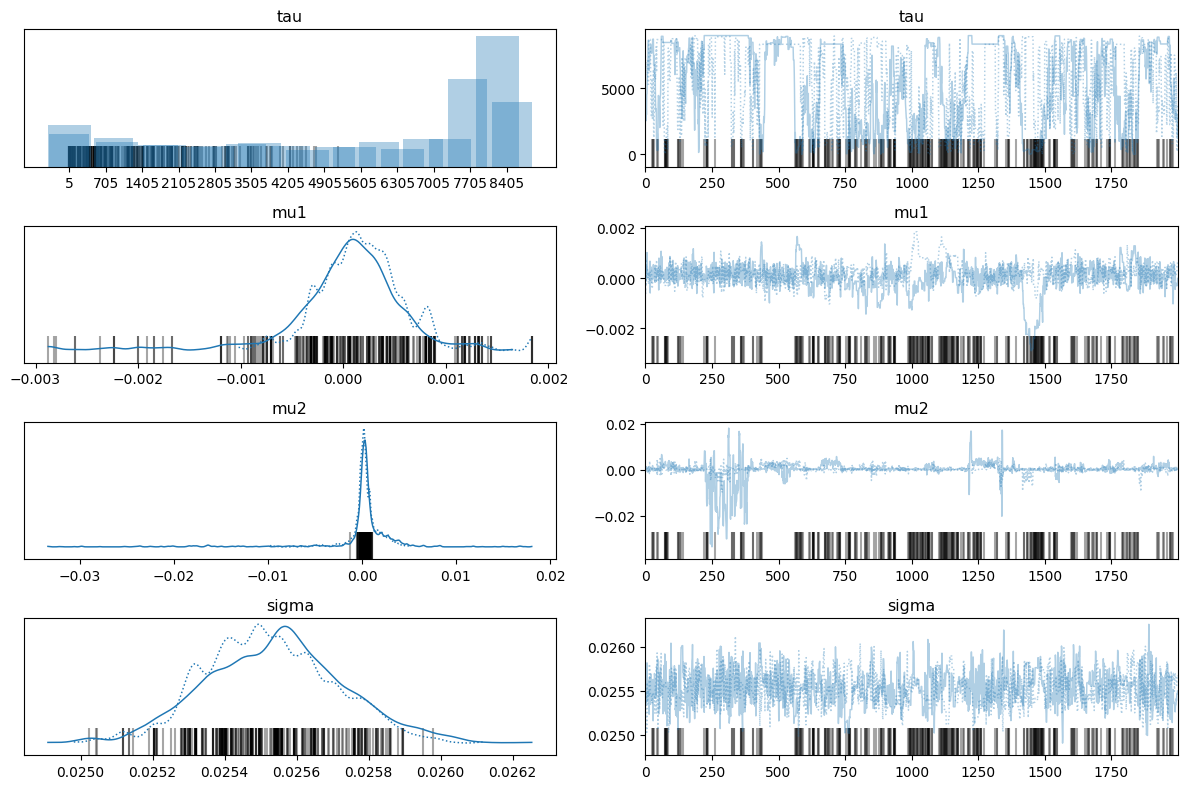

In [8]:
# --- Posterior analysis ---
az.plot_trace(trace, var_names=["tau", "mu1", "mu2", "sigma"])
plt.tight_layout()
plt.show()

In [9]:
# --- Summary ---
summary = az.summary(trace, var_names=["tau", "mu1", "mu2", "sigma"])
display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,5639.013,3052.336,495.000,9005.000,314.88,93.657,67.0,29.0,1.02
mu1,0.000,0.001,-0.001,0.001,0.00,0.000,86.0,118.0,1.03
mu2,0.000,0.003,-0.003,0.005,0.00,0.001,131.0,66.0,1.01
sigma,0.026,0.000,0.025,0.026,0.00,0.000,566.0,563.0,1.00


In [10]:
# --- Print the estimated change point ---
tau_mean = int(trace.posterior['tau'].mean().item())
change_date = df.iloc[tau_mean]['Date']
print(f"\n📍 Estimated Change Point: {change_date.date()} (Index: {tau_mean})")


📍 Estimated Change Point: 2009-07-27 (Index: 5639)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,5639.013,3052.336,495.000,9005.000,314.88,93.657,67.0,29.0,1.02
mu1,0.000,0.001,-0.001,0.001,0.00,0.000,86.0,118.0,1.03
mu2,0.000,0.003,-0.003,0.005,0.00,0.001,131.0,66.0,1.01
sigma,0.026,0.000,0.025,0.026,0.00,0.000,566.0,563.0,1.00


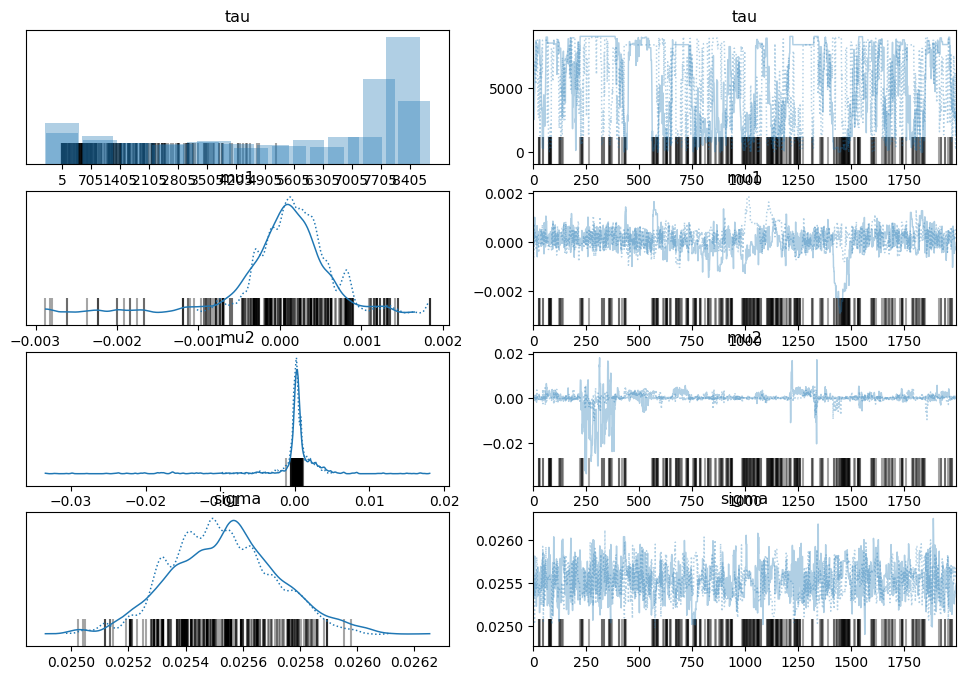

In [11]:
#Check for Convergence
az.plot_trace(trace, var_names=["tau", "mu1", "mu2", "sigma"])
az.summary(trace, var_names=["tau", "mu1", "mu2", "sigma"])

In [12]:
#Identify the Change Point
tau_mean = int(trace.posterior['tau'].mean().item())
change_date = df.iloc[tau_mean]['Date']
print(f"Estimated Change Point: {change_date.date()}")


Estimated Change Point: 2009-07-27


<Axes: title={'center': 'tau'}>

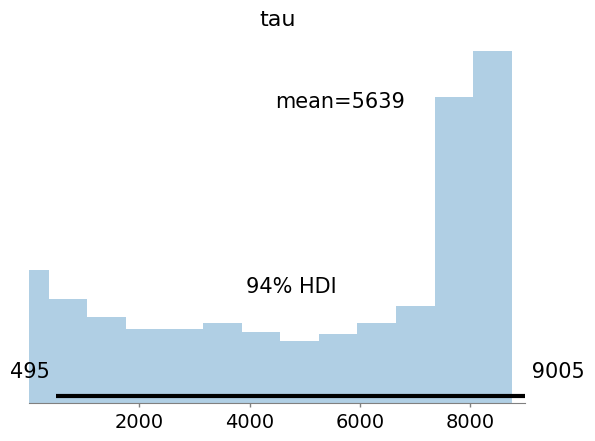

In [14]:
az.plot_posterior(trace, var_names=["tau"])

array([<Axes: title={'center': 'mu1'}>, <Axes: title={'center': 'mu2'}>],
      dtype=object)

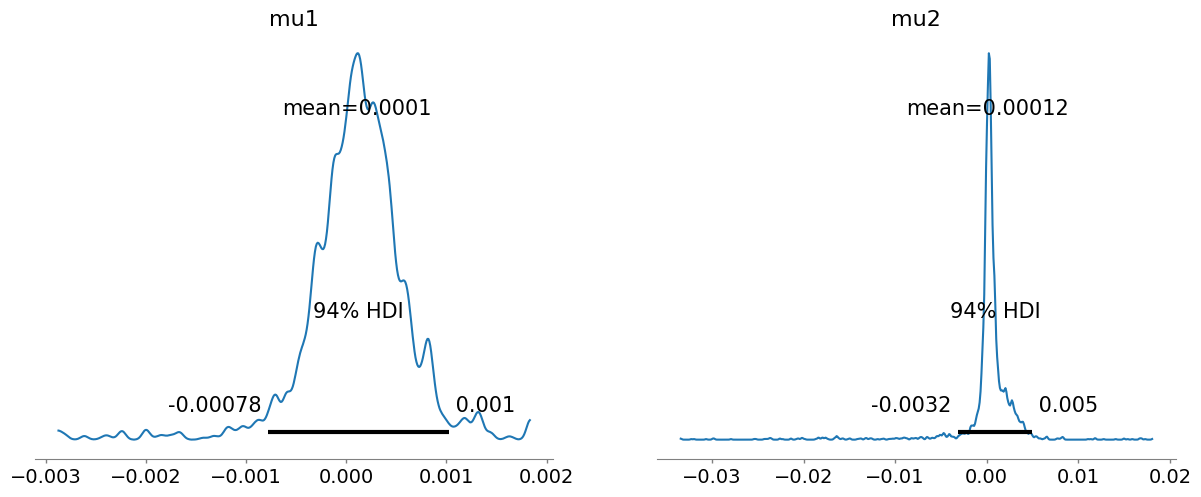

In [15]:
az.plot_posterior(trace, var_names=["mu1", "mu2"])

In [16]:
mu1_samples = trace.posterior['mu1'].values.flatten()
mu2_samples = trace.posterior['mu2'].values.flatten()

prob_higher = np.mean(mu2_samples > mu1_samples)
print(f"Probability that mu2 > mu1: {prob_higher:.2%}")

Probability that mu2 > mu1: 59.75%
